# Bevezetés

A mai labor témája a szemantikus szegmentáció implementációja lesz.

## Installálás

In [1]:
!pip3 install torch torchvision

## Installáció ellenőrzése

In [2]:
!nvcc --version
import torch
print(torch.cuda.is_available())

'nvcc' is not recognized as an internal or external command,
operable program or batch file.


False


## Adatbázis letöltése

In [3]:
!wget http://3dmr.iit.bme.hu/edu/DL/RoboCupSeg.zip
!unzip -qq RoboCupSeg.zip
!rm RoboCupSeg.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


# Megoldás

## DataLoader írása

### Segédfüggvények

In [4]:
import torch
import re

def tryint(s):
  try:
    return int(s)
  except:
    return s

def alphanum_key(s):
  """ Turn a string into a list of string and number chunks.
      "z23a" -> ["z", 23, "a"]
  """
  return [ tryint(c) for c in re.split('([0-9]+)', s) ]

class ToLabel(object):
  def __call__(self, tensor):
      return torch.squeeze(tensor.long())

### Random horizontal flip

In [5]:
from PIL import Image
import random

class HorizontalFlip(object):
  def __call__(self, img):
    if random.random() < 0.5:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    return img

### Loader

In [6]:
import torch
import os.path as osp
from torch.utils import data
import glob
import numpy as np

class SSDataSet(data.Dataset):
  def __init__(self, root, split="train", img_transform=None, label_transform=None):
    self.root = root
    self.split = split
    self.images = []
    self.labels = []
    self.labels = []
    self.img_transform = img_transform
    self.label_transform = label_transform

    data_dir = osp.join(root, split)
    self.img_dir = osp.join(data_dir,"images")
    self.lab_dir = osp.join(data_dir,"labels")

    imgFiles = sorted(glob.glob1(self.img_dir, "*.jpg"),key=alphanum_key)
    labFiles = sorted(glob.glob1(self.lab_dir, "*.png"),key=alphanum_key)
    
    for img,lab in zip(imgFiles,labFiles):
      self.images.append(img)
      self.labels.append(lab)


  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_file = osp.join( self.img_dir, self.images[index])
    lab_file = osp.join( self.lab_dir, self.labels[index])

    img = Image.open(img_file).convert('RGB')
    label = Image.open(lab_file).convert("I")

    seed = np.random.randint(2147483647)  # make a seed with numpy generator
    random.seed(seed)  # apply this seed to img tranfsorms
    if self.img_transform is not None:
      imgs = self.img_transform(img)
    else:
      imgs = img

    random.seed(seed)  # apply this seed to target tranfsorms
    if self.label_transform is not None:
      labels = self.label_transform(label)
    else:
      labels = label

    return imgs, labels

## Modell definiálása

### Conv réteg

In [7]:
import torch
import torch.nn as nn

class Conv(nn.Module):
  def __init__(self, inplanes, planes, size=3, stride=1):
    super(Conv, self).__init__()
    self.conv = nn.Conv2d(inplanes, planes, kernel_size=size, padding=size // 2, stride=stride)
    self.bn = nn.BatchNorm2d(planes)

  def forward(self, x):
    return self.bn(torch.relu(self.conv(x)))

### Transpose Conv

In [8]:
class trConv(nn.Module):
  def __init__(self, inplanes, planes, size=3, stride=2):
    super(trConv, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.ConvTranspose2d(inplanes, planes, kernel_size=size,
                          padding=size // 2, stride=stride, output_padding=1, bias=True)
    self.bn = nn.BatchNorm2d(planes)

  def forward(self, x):
    return self.bn(torch.relu(self.conv(x)))

### Modell

In [9]:
class FCN(nn.Module):
  def __init__(self, planes, numClass=5):
    super(FCN, self).__init__()
    self.c1 = Conv(3,planes)
    self.d1 = Conv(planes,planes*2,stride=2)
    self.c2 = Conv(planes*2,planes*2)
    self.d2 = Conv(planes*2,planes*4,stride=2)
    self.c3 = Conv(planes*4,planes*4)
    self.d3 = Conv(planes*4,planes*8,stride=2)
    self.c4 = Conv(planes*8,planes*8)
    self.d4 = Conv(planes*8,planes*16,stride=2)
    self.c5 = Conv(planes*16,planes*16)
    
    self.u1 = trConv(planes*16,planes*8)
    self.u2 = trConv(planes*8,planes*4)
    self.u3 = trConv(planes*4,planes*2)
    self.u4 = trConv(planes*2,planes)
    
    self.classifier = nn.Conv2d(planes,numClass,5,padding=2)
  
  def forward(self,x):
    l1 = self.c1(x)
    l2 = self.c2(self.d1(l1))
    l3 = self.c3(self.d2(l2))
    l4 = self.c4(self.d3(l3))
    l5 = self.c5(self.d4(l4))
    u4 = self.u1(l5) + l4
    u3 = self.u2(u4) + l3
    u2 = self.u3(u3) + l2
    u1 = self.u4(u2) + l1
    
    return self.classifier(u1)

In [12]:
!pip install torchsummary

In [15]:
from torchsummary import summary
summary(FCN(16, 10), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              Conv-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              Conv-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]           9,248
       BatchNorm2d-8           [-1, 32, 16, 16]              64
              Conv-9           [-1, 32, 16, 16]               0
           Conv2d-10             [-1, 64, 8, 8]          18,496
      BatchNorm2d-11             [-1, 64, 8, 8]             128
             Conv-12             [-1, 64, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          36,928
      BatchNorm2d-14             [-1, 6

## Train függvény

In [0]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def train(epoch):

  # variables for loss
  running_loss = 0.0
  correct = 0.0
  total = 0

  # set the network to train (for batchnorm and dropout)
  net.train()

  # Create progress bar
  bar = display(progress(0, len(trainLoader)), display_id=True)

  # Epoch loop
  for i, data in enumerate(trainLoader, 0):
    # get the inputs
    inputs, labels = data

    # Convert to cuda conditionally
    inputs, labels = inputs.cuda(), labels.cuda()


    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute statistics
    running_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += torch.sum( predicted.data == labels.data ).item()/(160*128)*100

    # Update progress bar
    bar.update(progress(i+1, len(trainLoader)))

  # print and plot statistics
  tr_loss = running_loss / len(trainLoader)
  tr_corr = correct / total
  print("Epoch [%d] Training Loss: %.4f Training Pixel Acc: %.2f" % (epoch+1, tr_loss, tr_corr))

  return tr_loss,tr_corr

## Val függvény

In [0]:
def val(epoch):

  # variables for loss
  running_loss = 0.0
  correct = 0.0
  total = 0
  
  # IoU computation
  conf = torch.zeros(numClass,numClass)
  IoU = torch.zeros(numClass)
  labCnts = torch.zeros(numClass)

  # set the network to eval (for batchnorm and dropout)
  net.eval()

  # Create progress bar
  bar = display(progress(0, len(testLoader)), display_id=True)

  # Epoch loop
  for i, data in enumerate(testLoader, 0):
    # get the inputs
    inputs, labels = data

    # Convert to cuda conditionally
    inputs, labels = inputs.cuda(), labels.cuda()

    # forward
    outputs = net(inputs)
    loss = criterion(outputs, labels)

    # compute statistics
    running_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += torch.sum( predicted.data == labels.data ).item()/(160*128)*100
    
    bSize = labels.size(0)
    labSize = labels.size()[1:3]
    
    # Compute IoU
    maskPred = torch.zeros(numClass,bSize,int(labSize[0]), int(labSize[1])).long()
    maskTarget = torch.zeros(numClass,bSize,int(labSize[0]), int(labSize[1])).long()
    for currClass in range(numClass):
      maskPred[currClass] = predicted == currClass
      maskTarget[currClass] = labels == currClass

    for imgInd in range(bSize):
      for labIdx in range(numClass):
        labCnts[labIdx] += torch.sum(maskTarget[labIdx,imgInd]).item()
        for predIdx in range(numClass):
          inter = torch.sum(maskPred[predIdx,imgInd] & maskTarget[labIdx,imgInd]).item()
          conf[(predIdx, labIdx)] += inter
          if labIdx == predIdx:
            union = torch.sum(maskPred[predIdx,imgInd] | maskTarget[labIdx,imgInd]).item()
            if union == 0:
              IoU[labIdx] += 1
            else:
              IoU[labIdx] += inter/union

    # Update progress bar
    bar.update(progress(i+1, len(testLoader)))

  # print and plot statistics
  for labIdx in range(numClass):
    for predIdx in range(numClass):
      conf[(predIdx, labIdx)] /= (labCnts[labIdx] / 100.0)
  meanClassAcc = 0.0
  meanIoU = torch.sum(IoU/total).item() / numClass * 100
  currLoss = running_loss/(i+1)
  for j in range(numClass):
    meanClassAcc += conf[(j,j)]/numClass
  print("Epoch [%d] Validation Loss: %.4f Validation Pixel Acc: %.2f Mean Class Acc: %.2f IoU: %.2f" %
        (epoch+1, running_loss/(i+1), correct/(total), meanClassAcc, meanIoU))

  return currLoss, correct/(total)

## Tanítás

### Dataloaderek

In [0]:
import torchvision
import torchvision.transforms as transforms
from PIL import Image

numClass = 5

input_transform = transforms.Compose([
    transforms.Resize((128,160), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))

])
target_transform = transforms.Compose([
    transforms.Resize((128,160), Image.NEAREST),
    transforms.ToTensor(),
    ToLabel(),
])

input_transform_tr = transforms.Compose([
    transforms.Resize((128,160),Image.BILINEAR),
    HorizontalFlip(),
    transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.4,hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))

])
target_transform_tr = transforms.Compose([
    transforms.Resize((128,160), Image.NEAREST),
    HorizontalFlip(),
    transforms.ToTensor(),
    ToLabel(),
])

trainLoader = data.DataLoader(SSDataSet("RoboCupSeg", split="train", img_transform=input_transform_tr,
                                             label_transform=target_transform_tr),
                                  batch_size=8, shuffle=True)

testLoader = data.DataLoader(SSDataSet("RoboCupSeg", split="val", img_transform=input_transform,
                                             label_transform=target_transform),
                                  batch_size=8, shuffle=True)

### Háló, Loss, Optimizer és Scheduler

Epoch [1] Training Loss: 1.1283 Training Pixel Acc: 74.09


Epoch [1] Validation Loss: 1.5679 Validation Pixel Acc: 82.91 Mean Class Acc: 42.54 IoU: 25.13


Epoch [2] Training Loss: 0.4164 Training Pixel Acc: 90.28


Epoch [2] Validation Loss: 0.2573 Validation Pixel Acc: 92.69 Mean Class Acc: 44.02 IoU: 32.55


Epoch [3] Training Loss: 0.2552 Training Pixel Acc: 92.37


Epoch [3] Validation Loss: 0.1861 Validation Pixel Acc: 94.18 Mean Class Acc: 49.01 IoU: 37.06


Epoch [4] Training Loss: 0.2336 Training Pixel Acc: 92.86


Epoch [4] Validation Loss: 0.1710 Validation Pixel Acc: 94.31 Mean Class Acc: 49.68 IoU: 38.35


Epoch [5] Training Loss: 0.2134 Training Pixel Acc: 93.54


Epoch [5] Validation Loss: 0.1975 Validation Pixel Acc: 93.96 Mean Class Acc: 49.23 IoU: 38.61


Epoch [6] Training Loss: 0.1787 Training Pixel Acc: 94.31


Epoch [6] Validation Loss: 0.1336 Validation Pixel Acc: 95.50 Mean Class Acc: 64.22 IoU: 46.02


Epoch [7] Training Loss: 0.1663 Training Pixel Acc: 94.78


Epoch [7] Validation Loss: 0.1304 Validation Pixel Acc: 95.61 Mean Class Acc: 67.83 IoU: 50.24


Epoch [8] Training Loss: 0.1486 Training Pixel Acc: 95.20


Epoch [8] Validation Loss: 0.1455 Validation Pixel Acc: 95.04 Mean Class Acc: 62.14 IoU: 47.68


Epoch [9] Training Loss: 0.1344 Training Pixel Acc: 95.60


Epoch [9] Validation Loss: 0.1393 Validation Pixel Acc: 95.53 Mean Class Acc: 63.91 IoU: 51.65


Epoch [10] Training Loss: 0.1122 Training Pixel Acc: 96.30


Epoch [10] Validation Loss: 0.1042 Validation Pixel Acc: 96.52 Mean Class Acc: 81.07 IoU: 58.99


Epoch [11] Training Loss: 0.1126 Training Pixel Acc: 96.18


Epoch [11] Validation Loss: 0.0991 Validation Pixel Acc: 96.61 Mean Class Acc: 73.87 IoU: 59.28


Epoch [12] Training Loss: 0.1072 Training Pixel Acc: 96.46


Epoch [12] Validation Loss: 0.0858 Validation Pixel Acc: 97.21 Mean Class Acc: 79.15 IoU: 62.62


Epoch [13] Training Loss: 0.0966 Training Pixel Acc: 96.72


Epoch [13] Validation Loss: 0.0821 Validation Pixel Acc: 97.27 Mean Class Acc: 79.24 IoU: 63.81


Epoch [14] Training Loss: 0.0966 Training Pixel Acc: 96.70


Epoch [14] Validation Loss: 0.0801 Validation Pixel Acc: 97.23 Mean Class Acc: 81.72 IoU: 63.42


Epoch [15] Training Loss: 0.0884 Training Pixel Acc: 96.94


Epoch [15] Validation Loss: 0.1027 Validation Pixel Acc: 96.75 Mean Class Acc: 78.15 IoU: 63.08


Epoch [16] Training Loss: 0.0915 Training Pixel Acc: 96.87


Epoch [16] Validation Loss: 0.0877 Validation Pixel Acc: 96.91 Mean Class Acc: 86.51 IoU: 64.36


Epoch [17] Training Loss: 0.0905 Training Pixel Acc: 96.89


Epoch [17] Validation Loss: 0.0779 Validation Pixel Acc: 97.34 Mean Class Acc: 81.71 IoU: 66.60


Epoch [18] Training Loss: 0.0856 Training Pixel Acc: 97.09


Epoch [18] Validation Loss: 0.0778 Validation Pixel Acc: 97.24 Mean Class Acc: 85.34 IoU: 64.39


Epoch [19] Training Loss: 0.0814 Training Pixel Acc: 97.15


Epoch [19] Validation Loss: 0.0720 Validation Pixel Acc: 97.55 Mean Class Acc: 83.94 IoU: 69.58


Epoch [20] Training Loss: 0.0891 Training Pixel Acc: 97.07


Epoch [20] Validation Loss: 0.0653 Validation Pixel Acc: 97.62 Mean Class Acc: 86.52 IoU: 68.10


Epoch [21] Training Loss: 0.0630 Training Pixel Acc: 97.74


Epoch [21] Validation Loss: 0.0594 Validation Pixel Acc: 97.87 Mean Class Acc: 87.62 IoU: 70.99


Epoch [22] Training Loss: 0.0605 Training Pixel Acc: 97.88


Epoch [22] Validation Loss: 0.0547 Validation Pixel Acc: 97.97 Mean Class Acc: 88.14 IoU: 72.14


Epoch [23] Training Loss: 0.0566 Training Pixel Acc: 97.96


Epoch [23] Validation Loss: 0.0577 Validation Pixel Acc: 98.00 Mean Class Acc: 87.89 IoU: 71.87


Epoch [24] Training Loss: 0.0554 Training Pixel Acc: 98.01


Epoch [24] Validation Loss: 0.0535 Validation Pixel Acc: 98.03 Mean Class Acc: 88.64 IoU: 72.63


Epoch [25] Training Loss: 0.0535 Training Pixel Acc: 98.08


Epoch [25] Validation Loss: 0.0548 Validation Pixel Acc: 98.05 Mean Class Acc: 89.01 IoU: 73.39


Epoch [26] Training Loss: 0.0525 Training Pixel Acc: 98.12


Epoch [26] Validation Loss: 0.0529 Validation Pixel Acc: 98.08 Mean Class Acc: 89.31 IoU: 73.38


Epoch [27] Training Loss: 0.0512 Training Pixel Acc: 98.16


Epoch [27] Validation Loss: 0.0546 Validation Pixel Acc: 98.07 Mean Class Acc: 88.70 IoU: 73.37


Epoch [28] Training Loss: 0.0505 Training Pixel Acc: 98.18


Epoch [28] Validation Loss: 0.0537 Validation Pixel Acc: 98.10 Mean Class Acc: 89.14 IoU: 74.55


Epoch [29] Training Loss: 0.0494 Training Pixel Acc: 98.20


Epoch [29] Validation Loss: 0.0520 Validation Pixel Acc: 98.15 Mean Class Acc: 89.75 IoU: 74.29


Epoch [30] Training Loss: 0.0503 Training Pixel Acc: 98.19


Epoch [30] Validation Loss: 0.0524 Validation Pixel Acc: 98.10 Mean Class Acc: 89.93 IoU: 74.55
Finished Training


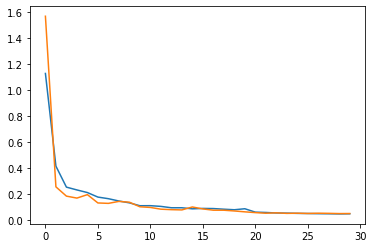

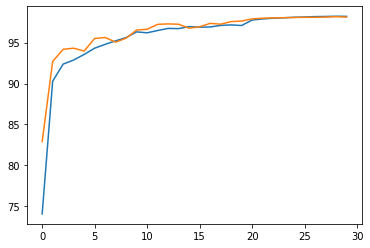

In [18]:
import torch.optim as optim
from torch.optim import lr_scheduler

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Makes multiple runs comparable
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

net = FCN(16,numClass).cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = lr_scheduler.StepLR(optimizer,20)

# Epoch counter
numEpoch = 30

trLosses = []
trAccs = []
valLosses = []
valAccs = []

for epoch in range(numEpoch):

  # Call train and val
  tr_loss,tr_corr = train(epoch)
  val_loss,val_corr = val(epoch)

  # Step with the scheduler
  scheduler.step()
  
  trLosses.append(tr_loss)
  trAccs.append(tr_corr)
  valLosses.append(val_loss)
  valAccs.append(val_corr)

# Finished
print('Finished Training')
plt.plot(trLosses)
plt.plot(valLosses)
plt.show()
plt.plot(trAccs)
plt.plot(valAccs)
plt.show()


## Vizualizáció

### Színezés

In [0]:
def Colorize(gray_image):
  cmap = torch.ByteTensor([[0,0,0],[255,0,0],[0,255,0],[0,0,255],[255,255,255]])
  size = gray_image.size()
  color_image = torch.ByteTensor(3, size[0], size[1]).fill_(0)

  for label in range(0, len(cmap)):
      mask = (label == gray_image).cpu()
      color_image[0][mask] = cmap[label][0]
      color_image[1][mask] = cmap[label][1]
      color_image[2][mask] = cmap[label][2]

  return color_image

### Egy minibatch

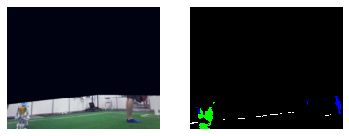

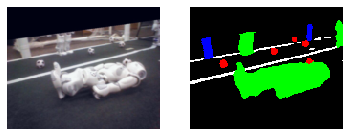

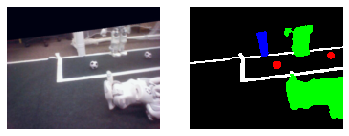

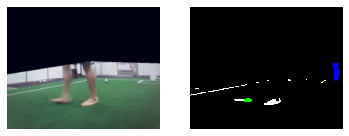

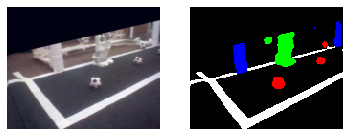

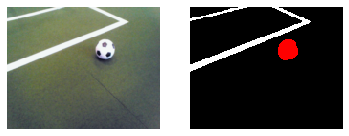

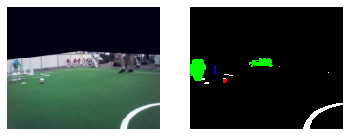

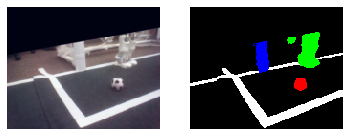

In [26]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

for i, (images, labels) in enumerate(testLoader):
    images = images.cuda()
    pred = net(images)
    _, predClass = torch.max(pred, 1)
    bSize = images.size(0)
    for j in range(bSize):
        label = Image.fromarray(Colorize(predClass[j]).permute(1, 2, 0).numpy().astype('uint8'))
        img = Image.fromarray(((images[j].permute(1, 2, 0).cpu().numpy()/4 + 0.5)*240).astype('uint8'))
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.grid(b=None)
        imshow(img)
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.grid(b=None)
        imshow(label)
    plt.show()
    break